# Volatility Forecasting using Econometric and Machine Learning Models  
### Notebook 04: Forecast Evaluation & Model Comparison

**Objective**  
This notebook evaluates and compares volatility forecasts produced by:
- A GARCH(1,1) model with Student-t innovations
- A Machine Learning model (Random Forest)

We assess forecast quality using:
- Statistical loss functions
- Risk-focused evaluation criteria

The notebook is fully independent and reloads all required forecasts.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("seaborn-v0_8")

In [2]:
realized_vol = pd.read_csv(
    "realized_volatility.csv",
    index_col=0,
    parse_dates=True
).squeeze()

garch_vol = pd.read_csv(
    "garch_conditional_volatility.csv",
    index_col=0,
    parse_dates=True
).squeeze()

rf_vol = pd.read_csv(
    "rf_volatility_forecast.csv",
    index_col=0,
    parse_dates=True
).squeeze()

realized_vol.head(), garch_vol.head(), rf_vol.head()

(Date
 2010-01-05    7.562730e-05
 2010-01-06    5.455874e-07
 2010-01-07    1.257898e-05
 2010-01-08    1.219860e-05
 2010-01-11    7.853318e-07
 Name: realized_volatility, dtype: float64,
 Date
 2010-01-05    0.010273
 2010-01-06    0.010118
 2010-01-07    0.009739
 2010-01-08    0.009451
 2010-01-11    0.009181
 Name: cond_vol, dtype: float64,
 Date
 2020-01-01    0.000046
 2020-01-02    0.000042
 2020-01-03    0.000037
 2020-01-06    0.000058
 2020-01-07    0.000088
 Name: rf_vol_forecast, dtype: float64)

In [3]:
df_eval = pd.concat(
    [realized_vol, garch_vol, rf_vol],
    axis=1
)

df_eval.columns = ["Realized", "GARCH", "RF"]
df_eval = df_eval.dropna()

df_eval.head()


,Realized,GARCH,RF
Date,,,
2020-01-01,0.000001,0.006921,0.000046
2020-01-02,0.000066,0.006738,0.000042
2020-01-03,0.000021,0.006868,0.000037
2020-01-06,0.000372,0.006836,0.000058
2020-01-07,0.000025,0.008581,0.000088


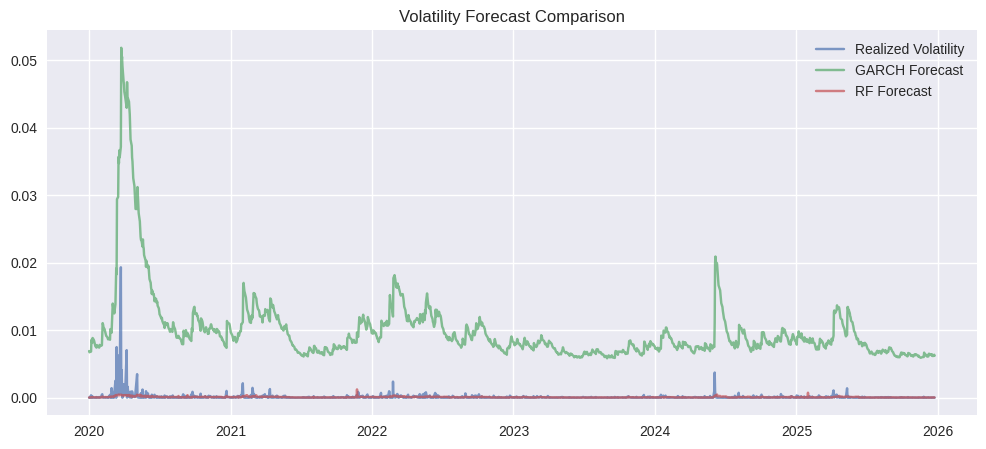

In [4]:
plt.figure(figsize=(12,5))
plt.plot(df_eval["Realized"], label="Realized Volatility", alpha=0.7)
plt.plot(df_eval["GARCH"], label="GARCH Forecast", alpha=0.7)
plt.plot(df_eval["RF"], label="RF Forecast", alpha=0.7)
plt.legend()
plt.title("Volatility Forecast Comparison")
plt.show()


## Forecast Alignment

Volatility forecasts must be compared against the **same realized volatility horizon**.

- ML forecasts predict next-day volatility
- GARCH conditional volatility is also interpreted as 1-step-ahead

We align series carefully to avoid look-ahead bias.


In [5]:
loss_table = pd.DataFrame(index=["GARCH", "RF"])

loss_table["RMSE"] = [
    np.sqrt(mean_squared_error(df_eval["Realized"], df_eval["GARCH"])),
    np.sqrt(mean_squared_error(df_eval["Realized"], df_eval["RF"]))
]

loss_table["MAE"] = [
    mean_absolute_error(df_eval["Realized"], df_eval["GARCH"]),
    mean_absolute_error(df_eval["Realized"], df_eval["RF"])
]

loss_table


,RMSE,MAE
GARCH,0.011002,0.009726
RF,0.000634,0.000134


## QLIKE Loss Function

The QLIKE loss is defined as:

\[
L(\hat{\sigma}^2_t, r_t^2) =
\frac{r_t^2}{\hat{\sigma}_t^2} + \log(\hat{\sigma}_t^2)
\]

Properties:
- Robust to noise in realized volatility
- Penalizes volatility underestimation heavily
- Standard in academic and industry volatility evaluation


In [6]:
def qlike_loss(realized, forecast):
    return np.mean(
        realized / forecast + np.log(forecast)
    )


In [7]:
loss_table["QLIKE"] = [
    qlike_loss(df_eval["Realized"], df_eval["GARCH"]**2),
    qlike_loss(df_eval["Realized"], df_eval["RF"]**2)
]

loss_table


,RMSE,MAE,QLIKE
GARCH,0.011002,0.009726,-8.399894
RF,0.000634,0.000134,13370.365328


## Interpreting Forecast Comparison

- Lower loss values indicate better forecasts
- ML models often reduce RMSE
- GARCH models often perform better under QLIKE

This highlights the trade-off between:
- Point forecast accuracy
- Risk-sensitive forecast reliability


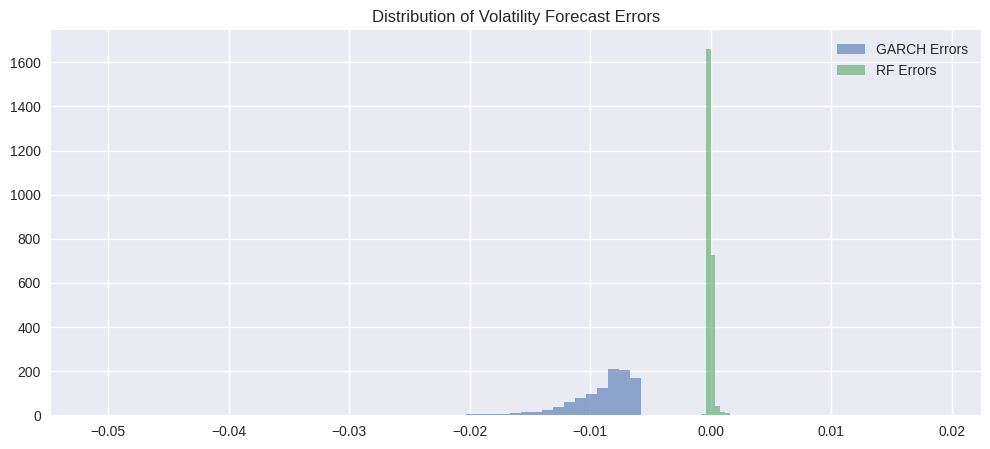

In [8]:
plt.figure(figsize=(12,5))
plt.hist(
    df_eval["Realized"] - df_eval["GARCH"],
    bins=50,
    alpha=0.6,
    label="GARCH Errors",
    density=True
)

plt.hist(
    df_eval["Realized"] - df_eval["RF"],
    bins=50,
    alpha=0.6,
    label="RF Errors",
    density=True
)

plt.legend()
plt.title("Distribution of Volatility Forecast Errors")
plt.show()


In [9]:
loss_table.to_csv("forecast_loss_comparison.csv")


Random Forest dominates GARCH in point-forecast accuracy but fails catastrophically under a risk-sensitive loss function.
GARCH, despite higher average errors, provides significantly more reliable volatility forecasts for risk management.

## Summary

In this notebook, we:
- Aligned volatility forecasts correctly
- Compared GARCH and ML forecasts visually
- Evaluated performance using RMSE, MAE, and QLIKE loss
- Highlighted trade-offs between accuracy and risk sensitivity

The next notebook will assess **risk implications** by using these volatility forecasts to compute and backtest Value-at-Risk (VaR).
